***Clustering Pipeline Bert***

Imports

In [3]:
from datasets import load_dataset, concatenate_datasets
import torch
import numpy as np
from tqdm.auto import tqdm


/Users/leosteiner/Desktop/BT/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Model + Tokenizer

In [4]:
model_path = "./bert-finetuned"
from transformers import (BertTokenizerFast,BertForSequenceClassification)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

Load Dataset

In [5]:
# Load dataset
dataset = load_dataset('imdb')
train_data = dataset["train"]
test_data = dataset["test"]


Core Grad-L2 saliency for a single example
The goal of this function is:

For each token in the input, compute a saliency score that measures how much that token influenced the model’s output for some class (e.g., the predicted label).

The method used:
1. Convert input_ids → embedding vectors (word_embeds).
2. Treat those embeddings as a leaf tensor with requires_grad=True, so we can compute gradients w.r.t. them.
3. Run a forward pass with inputs_embeds=word_embeds instead of input_ids.
4. Take the logit (score) of the class we care about.
5. Call backward() to get ∂score/∂embedding for each token.
6. Compute a norm over the embedding dimension to get one scalar importance per token.
7. Convert everything to CPU / numpy and map back to token strings.

In [6]:
def grad_l2_saliency(
    text: str,
    model,
    tokenizer,
    device,
    target_class: int | None = None,
    max_length: int = 512
):
    """
    Compute Grad-L2 saliency for one input text.

    Returns:
        tokens: list[str]          # wordpiece tokens incl. special tokens
        saliency: np.ndarray       # shape (seq_len,)
        input_ids: np.ndarray      # token ids (same length as saliency)
    """
    model.eval()

    # 1) Tokenize
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)           # [1, L] L = sequence length
    attention_mask = enc["attention_mask"].to(device) # [1, L]
    token_type_ids = enc.get("token_type_ids")
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    # 2) Get word embeddings and make them a leaf tensor with grad
    with torch.no_grad():
        word_embeds = model.bert.embeddings.word_embeddings(input_ids)
    word_embeds = word_embeds.detach().requires_grad_(True)  # [1, L, H]

    # 3) Forward pass using inputs_embeds so we can backprop to embeddings
    model.zero_grad()
    outputs = model(
        inputs_embeds=word_embeds, #pass embeddings instead of input_ids
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    logits = outputs.logits  # [1, num_labels]

    # 4) Choose the logit to explain: pick predicted label by default
    if target_class is None:
        target_class = logits.argmax(dim=-1).item()  # predicted label

    # using the predicted class as scalar for autograd
    score = logits[0, target_class] # standard tensor indexing: tensor[row_index, column_index]

    # 5) Backward: d score / d word_embeds # computes gradients of score with respect to all tensors that have requires_grad=True in the computation graph.
    score.backward()

    grads = word_embeds.grad  # [1, L, H] store gradient 

    # 6) L2 norm over hidden dimension -> one score per token
    saliency = torch.norm(grads, p=2, dim=-1).squeeze(0)  # [1,L,H ] -> [1,L] -> [L] collapsing H

    # 7) Move to CPU / numpy
    saliency = saliency.detach().cpu().numpy()
    input_ids_cpu = input_ids.squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids_cpu)

    return tokens, saliency, input_ids_cpu


In [7]:
# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# move to device
model.to(device)

#eval mode
model.eval()

# Single IMDB review for testing
text = test_data[0]["text"]     
tokens, sal, ids = grad_l2_saliency(text, model, tokenizer, device)

Simple bar plot over tokens

In [22]:
import matplotlib.pyplot as plt

def plot_token_saliency(tokens, saliency, title=None, max_tokens=50):
    # Optionally truncate long sequences for readability
    tokens = tokens[:max_tokens]
    saliency = saliency[:max_tokens]

    # Normalize for nicer plotting (0..1)
    sal_norm = saliency / (saliency.max() + 1e-12) # use 1e-12 to prevent zero division error

    plt.figure(figsize=(0.4 * len(tokens), 8))
    plt.bar(range(len(tokens)), sal_norm)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel("Normalized Grad-L2")
    if title is not None:
        plt.title(title)
    # plt.tight_layout()
    plt.show()


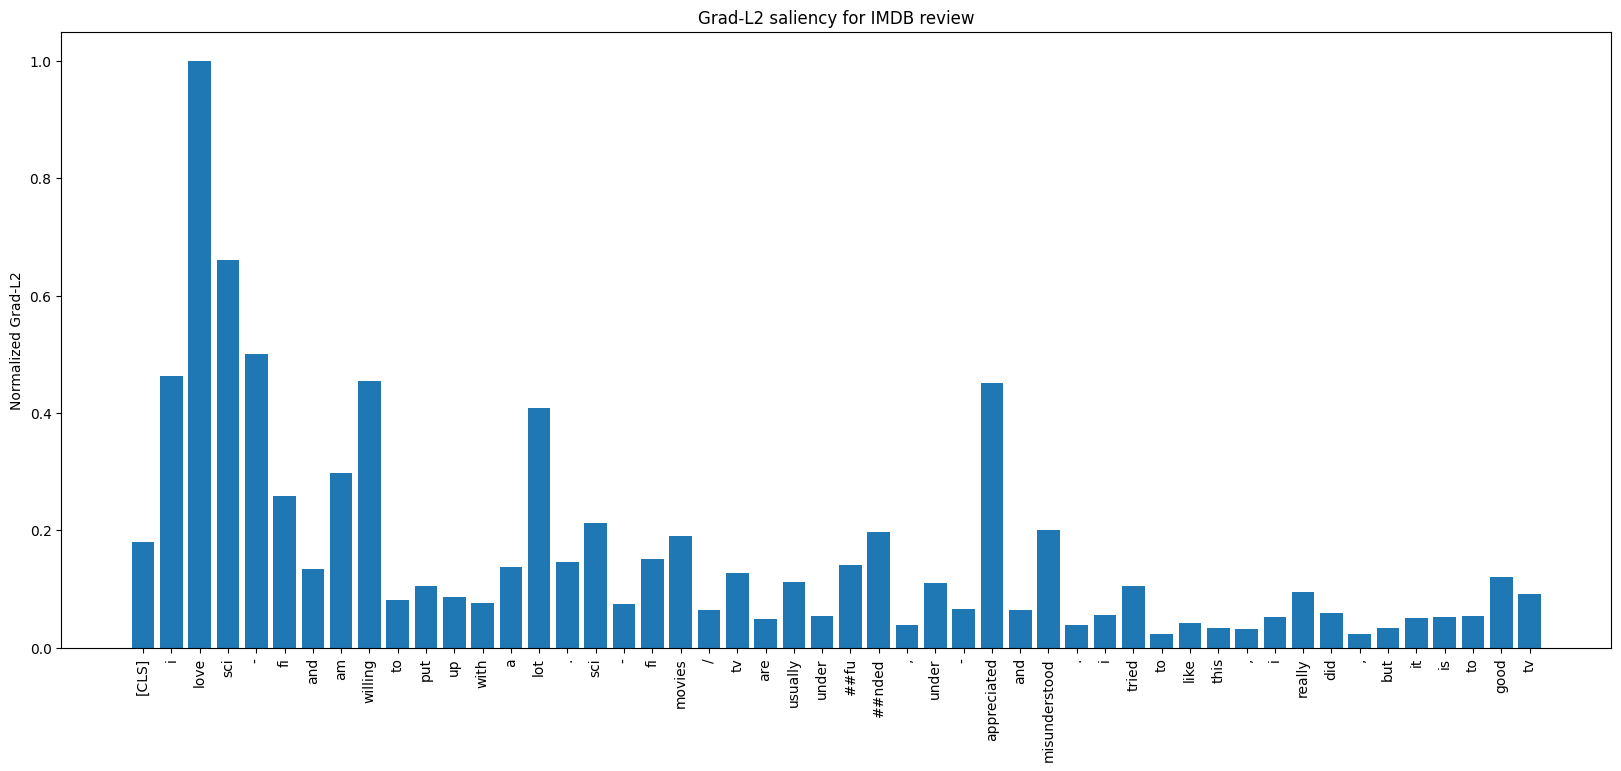

In [23]:
plot_token_saliency(tokens, sal, title="Grad-L2 saliency for IMDB review")


### Color coded text ###

In [ ]:
from matplotlib import colors as mcolors
from IPython.display import HTML, display

def html_colorize(tokens, saliency, max_tokens=200):
    tokens = tokens[:max_tokens]
    saliency = saliency[:max_tokens]
    sal_norm = saliency / (saliency.max() + 1e-12) # use 1e-12 to prevent zero division error

    cmap = plt.cm.cividis  # civids works pretty well as colormap
    html_tokens = []
    for tok, s in zip(tokens, sal_norm):
        rgba = cmap(s)
        color = mcolors.to_hex(rgba)
        html_tokens.append(
            f'<span style="background-color:{color}; padding:2px; margin:1px;">{tok}</span>'
        )
    html = "<div style='font-family: monospace; line-height: 1.7;'>" + " ".join(html_tokens) + "</div>"
    display(HTML(html))


In [27]:
html_colorize(tokens, sal)


### Grad-L2 for many ecamples + vocab ###

Aggregating token-level salience into a fixed-length, interpretable vector so we can analyze the dataset and model in bulk, rather than inspecting individual examples manually.

1. Initialize a vocabulary-sized zero vector.
2. Fill each token’s vocab position with its max absolute salience.
3. Identify the top-k highest salience entries.
4. Zero out all other entries.
5. Return the sparse salience vector.

In [ ]:
def saliency_to_vocab_vector(input_ids, saliency, vocab_size, top_k=5):
    """
    Implements S1 from the paper: a |V|-dim vector with the
    max |saliency| per vocab item, zeroed except for top-k entries.
    """
    r = np.zeros(vocab_size, dtype=np.float32) #expecting vocab size of bert tokenzier

    for tok_id, s in zip(input_ids, saliency):
        tok_id = int(tok_id)
        r[tok_id] = max(r[tok_id], abs(float(s))) # get max saliency value

    if top_k is not None and top_k < vocab_size:
        # Keep only top-k entries, zero out the rest
        if np.count_nonzero(r) > top_k: # count how many positoons in r are not zero
            top_idx = np.argpartition(r, -top_k)[-top_k:]
            mask = np.zeros_like(r)
            mask[top_idx] = r[top_idx]
            r = mask

    return r


Build the Vocab

In [ ]:
from tqdm.auto import tqdm

def build_salience_vocab_matrix(dataset, model, tokenizer, device, 
                                split="test", n_examples=2500, top_k=5, max_length=512):
    """
    dataset: HF datasets.DatasetDict with 'train'/'test'
    Returns:
        R_vocab: np.ndarray [N, |V|]
        texts: list[str]
    """
    ds = dataset[split]
    n = min(n_examples, len(ds))
    vocab_size = tokenizer.vocab_size

    R_rows = []
    texts = []

    for i in tqdm(range(n)):
        text = ds[i]["text"]
        tokens, sal, ids = grad_l2_saliency(
            text, model, tokenizer, device, max_length=max_length
        )
        r = saliency_to_vocab_vector(ids, sal, vocab_size, top_k=top_k)
        R_rows.append(r)
        texts.append(text)

    R_vocab = np.stack(R_rows, axis=0)  # [N, |V|]

    # Row-wise L2 normalization, as in the paper :contentReference[oaicite:2]{index=2}
    norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-12
    R_vocab = R_vocab / norms

    return R_vocab, texts

In [24]:
R_vocab, texts = build_salience_vocab_matrix(
    dataset, model, tokenizer, device,
    split="test", n_examples=2500, top_k=5
)


100%|██████████| 2500/2500 [03:20<00:00, 12.46it/s]


Clustering

In [25]:
from sklearn.cluster import KMeans

def cluster_salience(R_vocab, n_clusters=5, random_state=0):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_ids = kmeans.fit_predict(R_vocab)
    return cluster_ids, kmeans


In [26]:
cluster_ids, kmeans = cluster_salience(R_vocab, n_clusters=5)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
from sklearn.manifold import TSNE

def plot_tsne(R_vocab, cluster_ids, sample_size=2000):
    # Optionally subsample to keep t-SNE fast
    n = min(sample_size, R_vocab.shape[0])
    R_sub = R_vocab[:n]
    c_sub = cluster_ids[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=c_sub, s=8, cmap="tab10")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE of Grad-L2 salience vocab representations (IMDB)")
    plt.tight_layout()
    plt.show()


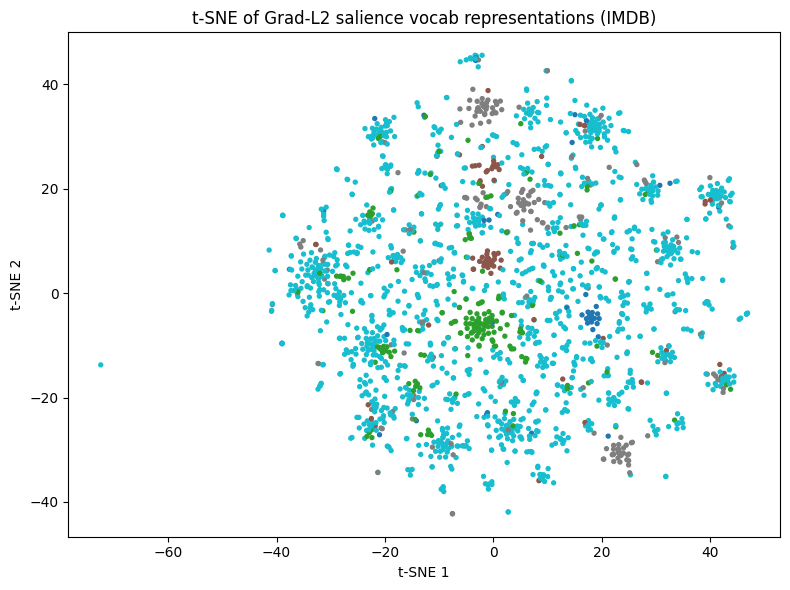

In [28]:
plot_tsne(R_vocab, cluster_ids, sample_size=2000)


In [32]:
import torch
from torch.utils.data import DataLoader

def predict_labels(dataset_split, model, tokenizer, device, batch_size=32, max_length=512):
    model.eval()
    loader = DataLoader(dataset_split, batch_size=batch_size, shuffle=False)

    all_preds = []
    with torch.no_grad():
        for batch in loader:
            texts = batch["text"]
            enc = tokenizer(
                list(texts),
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=max_length,
            ).to(device)

            logits = model(**enc).logits  # [B, 2]
            preds = logits.argmax(dim=-1).cpu()
            all_preds.extend(preds.tolist())

    return all_preds


In [33]:
test_preds = predict_labels(test_data, model, tokenizer, device)


In [34]:
import numpy as np
from tqdm.auto import tqdm

def build_salience_vocab_matrix_from_indices(
    dataset_split,
    indices,
    model,
    tokenizer,
    device,
    top_k=5,
    max_length=512,
):
    vocab_size = tokenizer.vocab_size
    R_rows = []
    texts = []

    for idx in tqdm(indices):
        text = dataset_split[idx]["text"]
        tokens, sal, ids = grad_l2_saliency(
            text, model, tokenizer, device, max_length=max_length
        )
        r = saliency_to_vocab_vector(ids, sal, vocab_size, top_k=top_k)
        R_rows.append(r)
        texts.append(text)

    R_vocab = np.stack(R_rows, axis=0)
    # row-wise L2 normalization as in the paper :contentReference[oaicite:1]{index=1}
    norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-12
    R_vocab = R_vocab / norms
    return R_vocab, texts

# select indices of negatively predicted examples
neg_indices = [i for i, p in enumerate(test_preds) if p == 0]  # adjust if your label mapping is reversed
len(neg_indices)

# sample 2500 of them (or fewer if you have less)
np.random.seed(0)
sample_size = min(2500, len(neg_indices))
neg_sample_indices = np.random.choice(neg_indices, size=sample_size, replace=False)

R_vocab, texts_neg = build_salience_vocab_matrix_from_indices(
    test_data,
    neg_sample_indices,
    model,
    tokenizer,
    device,
    top_k=5,
)


100%|██████████| 2500/2500 [02:29<00:00, 16.69it/s]


In [35]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_ids = kmeans.fit_predict(R_vocab)


In [36]:
from collections import defaultdict

def describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=5):
    vocab_size = tokenizer.vocab_size
    cluster_to_indices = defaultdict(list)
    for i, c in enumerate(cluster_ids):
        cluster_to_indices[c].append(i)

    for c in sorted(cluster_to_indices.keys()):
        idxs = cluster_to_indices[c]
        cluster_matrix = R_vocab[idxs]           # [Nc, |V|]
        mean_sal = cluster_matrix.mean(axis=0)   # [|V|]

        # get top-m tokens by mean salience
        top_ids = mean_sal.argsort()[-top_m_terms:][::-1]
        
        tokens = tokenizer.convert_ids_to_tokens(top_ids.tolist())
        # optionally filter out obvious junk like [CLS], [SEP], punctuation
        filtered = [
            t for t in tokens
            if t not in tokenizer.all_special_tokens and t.isalnum()
        ]

        print(f"Cluster {c}")
        print(f"  Size: {len(idxs)} examples ({len(idxs)/len(R_vocab):.2%} of sample)")
        print(f"  Top terms: {', '.join(filtered[:top_m_terms])}")
        print("-" * 60)

describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=5)


Cluster 0
  Size: 28 examples (1.12% of sample)
  Top terms: liked, boring, annoying, 4, awful
------------------------------------------------------------
Cluster 1
  Size: 270 examples (10.80% of sample)
  Top terms: bad, great, boring, awful, not
------------------------------------------------------------
Cluster 2
  Size: 443 examples (17.72% of sample)
  Top terms: worst, awful, great, horrible, 1
------------------------------------------------------------
Cluster 3
  Size: 152 examples (6.08% of sample)
  Top terms: terrible, great, worst, 4, awful
------------------------------------------------------------
Cluster 4
  Size: 1607 examples (64.28% of sample)
  Top terms: great, 4, waste, boring, 3
------------------------------------------------------------


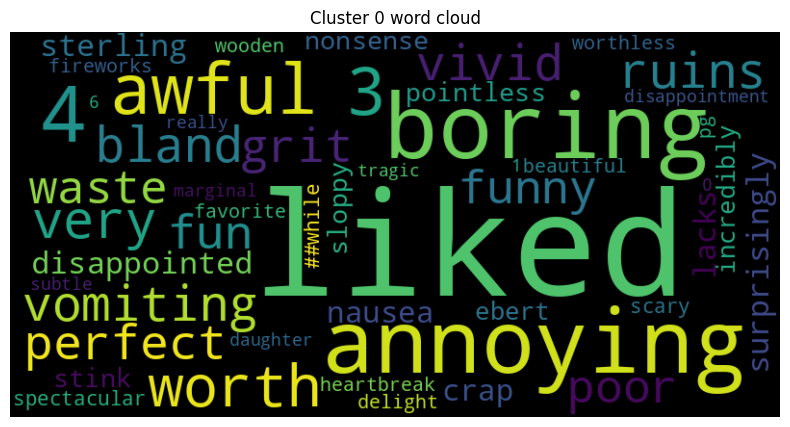

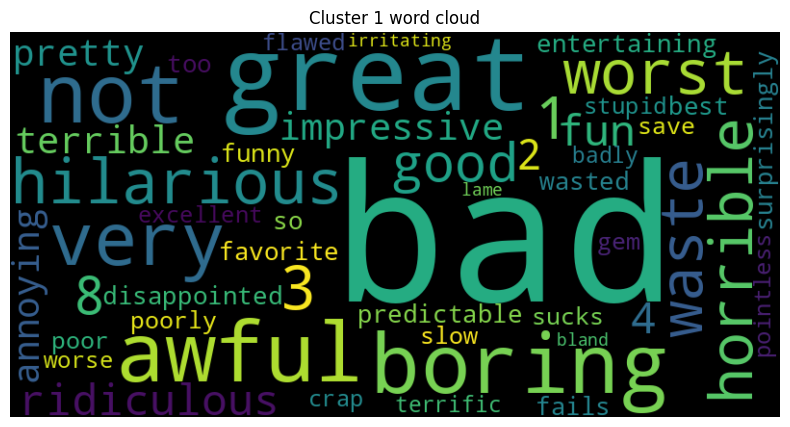

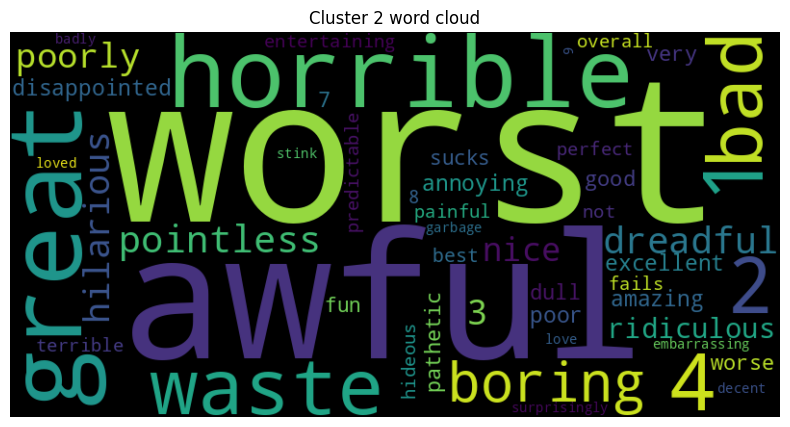

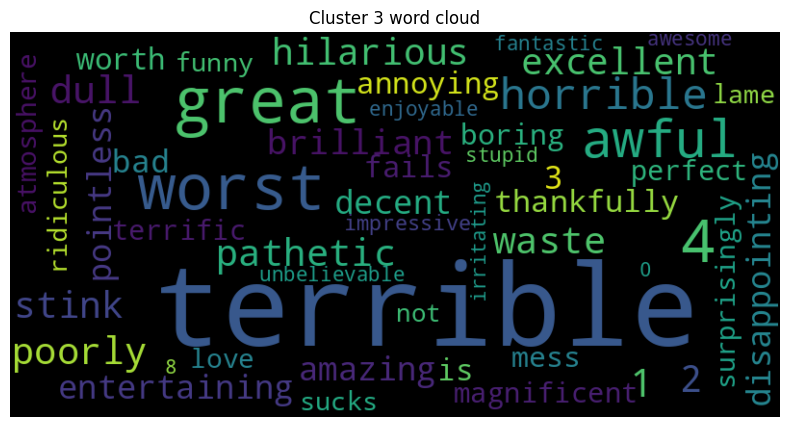

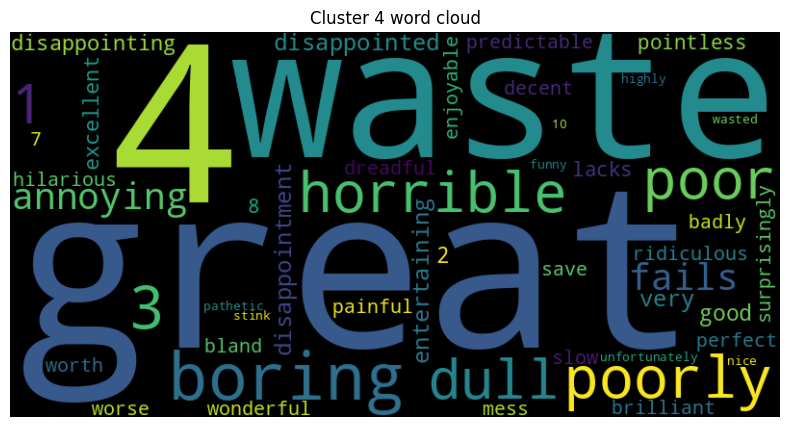

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id, max_words=50):
    idxs = [i for i, c in enumerate(cluster_ids) if c == cluster_id]
    cluster_matrix = R_vocab[idxs]
    mean_sal = cluster_matrix.mean(axis=0)

    # build {token: weight} dict
    token_weights = {}
    for tok_id, w in enumerate(mean_sal):
        if w <= 0:
            continue
        tok = tokenizer.convert_ids_to_tokens([tok_id])[0]
        if tok in tokenizer.all_special_tokens:
            continue
        if tok.strip() == "":
            continue
        token_weights[tok] = float(w)

    wc = WordCloud(width=800, height=400, max_words=max_words)
    wc.generate_from_frequencies(token_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} word cloud")
    plt.show()

# Example: visualize all clusters
for c in range(n_clusters):
    cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id=c)


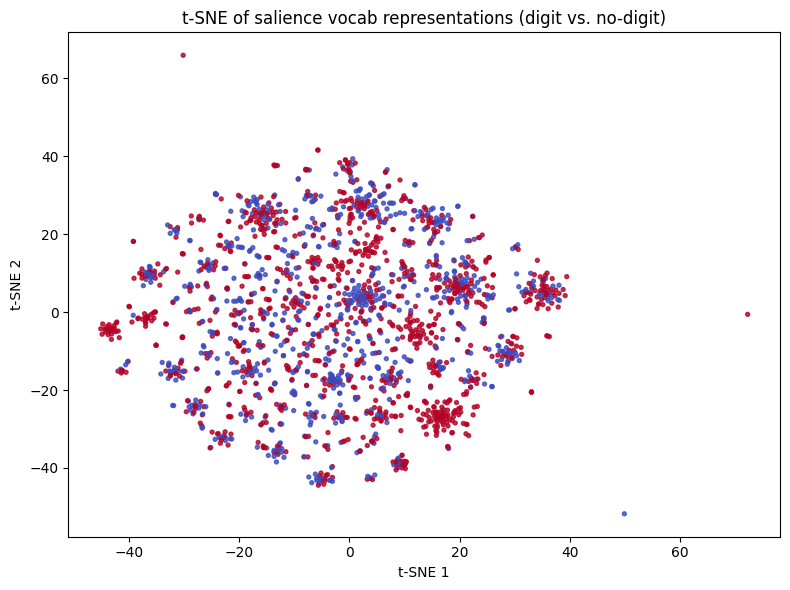

In [39]:
from sklearn.manifold import TSNE

def plot_tsne_with_digits(R_vocab, texts, sample_size=2000):
    n = min(sample_size, R_vocab.shape[0])
    R_sub = R_vocab[:n]
    texts_sub = texts[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    # Color points depending on whether text contains digits
    has_digit = np.array([int(any(ch.isdigit() for ch in t)) for t in texts_sub])

    plt.figure(figsize=(8, 6))
    plt.scatter(
        coords[:, 0],
        coords[:, 1],
        c=has_digit,
        s=8,
        cmap="coolwarm",
        alpha=0.8,
    )
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE of salience vocab representations (digit vs. no-digit)")
    plt.tight_layout()
    plt.show()

plot_tsne_with_digits(R_vocab, texts_neg)


In [40]:
import re

rating_pattern = re.compile(r"\b\d+\s*/\s*10\b|\b\d+\s*star[s]?\b|\brating\b", re.IGNORECASE)

def is_numeric_example(text):
    return bool(rating_pattern.search(text))

labels_numeric = np.array([is_numeric_example(t) for t in texts_neg])

# identify numeric cluster: the one whose top tokens are mostly digits
numeric_cluster_id = 3  # adjust after looking at describe_clusters

cluster_mask = (np.array(cluster_ids) == numeric_cluster_id)

precision = labels_numeric[cluster_mask].mean() if cluster_mask.any() else 0.0
recall = (labels_numeric[cluster_mask].sum() / labels_numeric.sum()) if labels_numeric.sum() > 0 else 0.0

print(f"Numeric cluster {numeric_cluster_id}: precision={precision:.2f}, recall={recall:.2f}")


Numeric cluster 3: precision=0.12, recall=0.07


Example 0
Predicted label: 0
I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's 

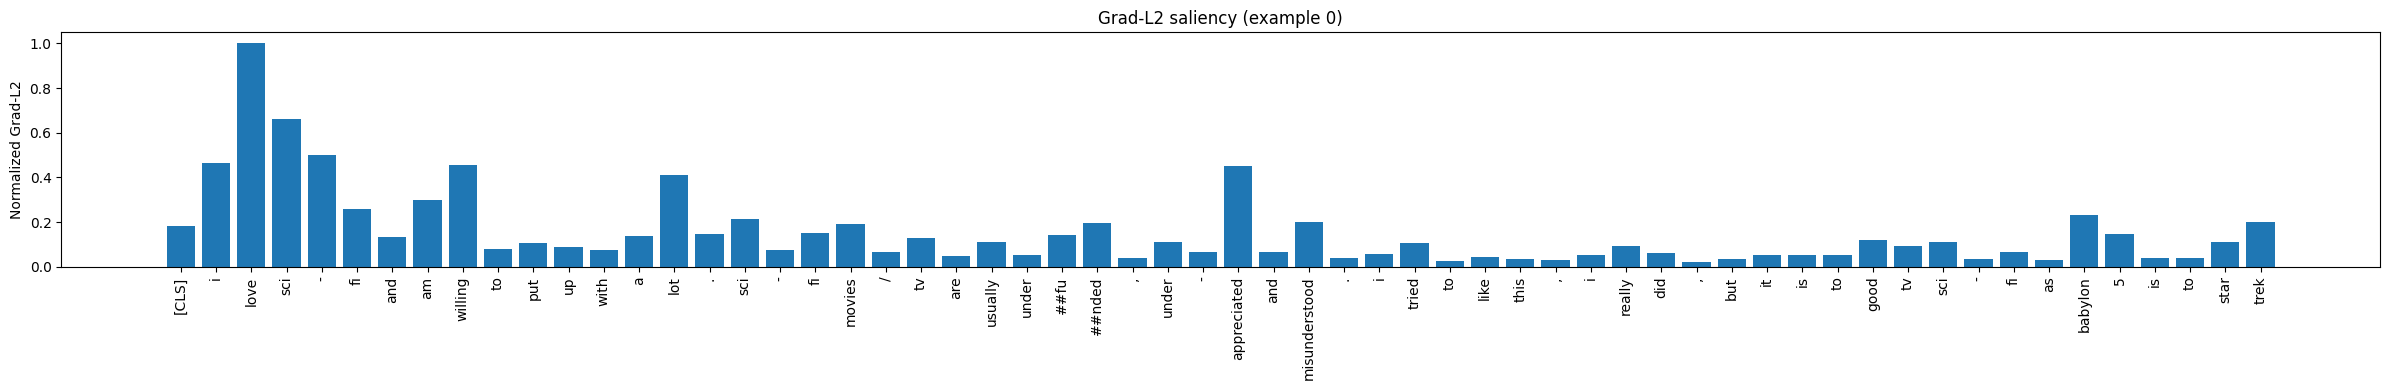

In [43]:
import torch
import matplotlib.pyplot as plt

def plot_token_saliency(tokens, saliency, title=None, max_tokens=60):
    tokens = tokens[:max_tokens]
    saliency = saliency[:max_tokens]
    sal_norm = saliency / (saliency.max() + 1e-12)

    plt.figure(figsize=(0.4 * len(tokens), 4))
    plt.bar(range(len(tokens)), sal_norm)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel("Normalized Grad-L2")
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()


def inspect_example(idx):
    text = test_data[idx]["text"]
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        logits = model(**enc).logits
        pred = logits.argmax(-1).item()

    tokens, sal, ids = grad_l2_saliency(text, model, tokenizer, device)

    print(f"Example {idx}")
    print(f"Predicted label: {pred}")
    print("=" * 80)
    print(text[:1000], "..." if len(text) > 1000 else "")
    print("=" * 80)

    plot_token_saliency(tokens, sal, title=f"Grad-L2 saliency (example {idx})")


# try a few indices
inspect_example(0)


In [44]:
from torch.utils.data import DataLoader

def predict_labels(dataset_split, model, tokenizer, device, batch_size=32, max_length=512):
    model.eval()
    loader = DataLoader(dataset_split, batch_size=batch_size, shuffle=False)

    all_preds = []
    with torch.no_grad():
        for batch in loader:
            texts = batch["text"]
            enc = tokenizer(
                list(texts),
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=max_length,
            ).to(device)

            logits = model(**enc).logits
            preds = logits.argmax(dim=-1).cpu()
            all_preds.extend(preds.tolist())
    return all_preds

test_preds = predict_labels(test_data, model, tokenizer, device)
len(test_preds), test_preds[:10]


(25000, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [45]:
import numpy as np
from tqdm.auto import tqdm

def build_salience_vocab_matrix_from_indices(
    dataset_split,
    indices,
    model,
    tokenizer,
    device,
    top_k=5,
    max_length=512,
):
    vocab_size = tokenizer.vocab_size
    rows = []
    texts = []

    for idx in tqdm(indices):
        text = dataset_split[idx]["text"]
        tokens, sal, ids = grad_l2_saliency(
            text, model, tokenizer, device, max_length=max_length
        )
        r = saliency_to_vocab_vector(ids, sal, vocab_size, top_k=top_k)
        rows.append(r)
        texts.append(text)

    R_vocab = np.stack(rows, axis=0)
    norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-12
    R_vocab = R_vocab / norms
    return R_vocab, texts

# indices of negative predictions (change == 0 if your negative label is 0)
neg_indices = [i for i, p in enumerate(test_preds) if p == 0]
print("Negative examples in test:", len(neg_indices))

np.random.seed(0)
sample_size = min(2500, len(neg_indices))
neg_sample_indices = np.random.choice(neg_indices, size=sample_size, replace=False)

R_vocab, texts_neg = build_salience_vocab_matrix_from_indices(
    test_data,
    neg_sample_indices,
    model,
    tokenizer,
    device,
    top_k=5,
)
R_vocab.shape


Negative examples in test: 12019


100%|██████████| 2500/2500 [02:15<00:00, 18.47it/s]


(2500, 30522)

In [46]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_ids = kmeans.fit_predict(R_vocab)
np.bincount(cluster_ids)


array([  28,  270,  443,  152, 1607])

In [47]:
from collections import defaultdict

def describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=5):
    cluster_to_indices = defaultdict(list)
    for i, c in enumerate(cluster_ids):
        cluster_to_indices[c].append(i)

    for c in sorted(cluster_to_indices.keys()):
        idxs = cluster_to_indices[c]
        cluster_matrix = R_vocab[idxs]
        mean_sal = cluster_matrix.mean(axis=0)

        top_ids = mean_sal.argsort()[-top_m_terms:][::-1]
        tokens = tokenizer.convert_ids_to_tokens(top_ids.tolist())

        # light filtering
        filtered = [
            t for t in tokens
            if t not in tokenizer.all_special_tokens and t.strip() != ""
        ]

        print(f"Cluster {c}")
        print(f"  Size: {len(idxs)} ({len(idxs)/len(R_vocab):.2%} of sample)")
        print(f"  Top terms: {', '.join(filtered[:top_m_terms])}")
        print("-" * 60)

describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=7)


Cluster 0
  Size: 28 (1.12% of sample)
  Top terms: liked, boring, annoying, 4, awful, 3, worth
------------------------------------------------------------
Cluster 1
  Size: 270 (10.80% of sample)
  Top terms: bad, great, boring, awful, not, very, hilarious
------------------------------------------------------------
Cluster 2
  Size: 443 (17.72% of sample)
  Top terms: worst, awful, great, horrible, 1, 4, waste
------------------------------------------------------------
Cluster 3
  Size: 152 (6.08% of sample)
  Top terms: terrible, great, worst, 4, awful, horrible, 1
------------------------------------------------------------
Cluster 4
  Size: 1607 (64.28% of sample)
  Top terms: great, 4, waste, boring, 3, poorly, horrible
------------------------------------------------------------


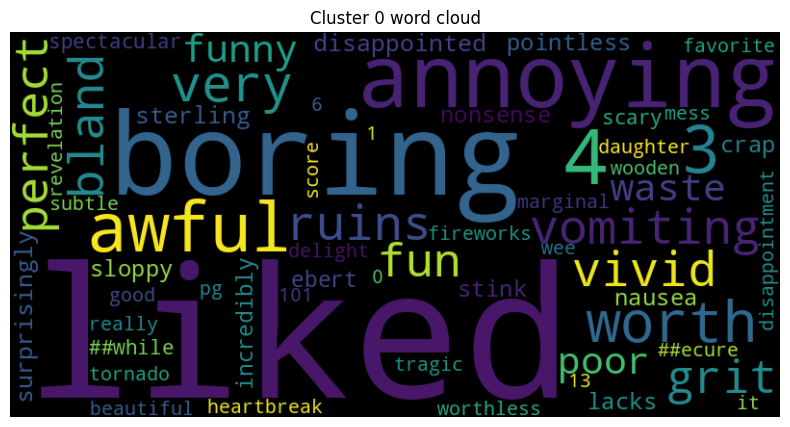

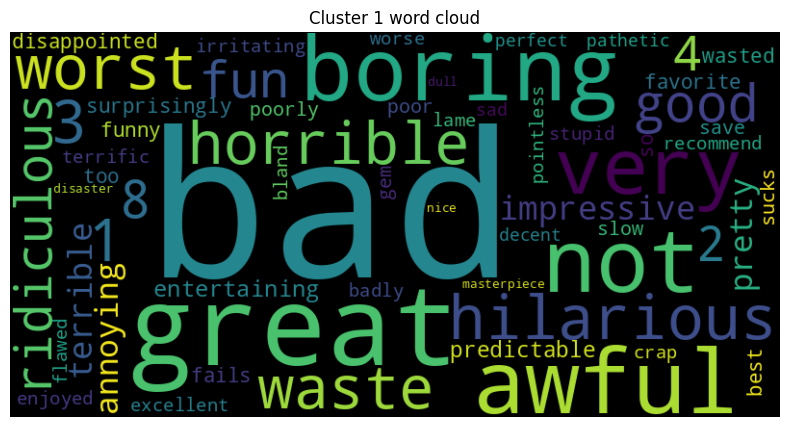

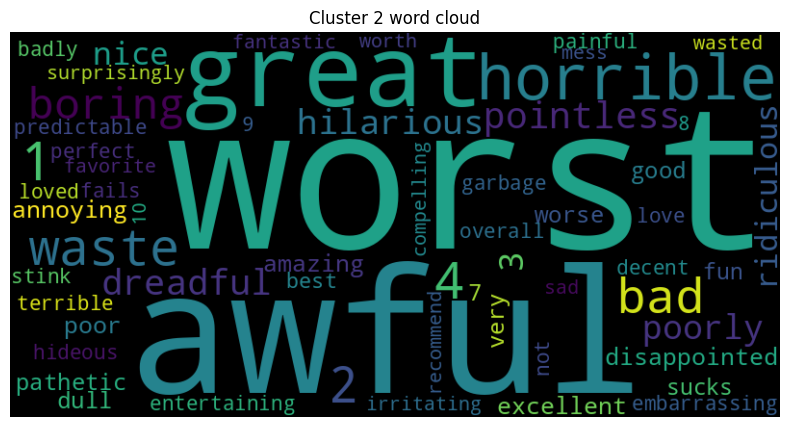

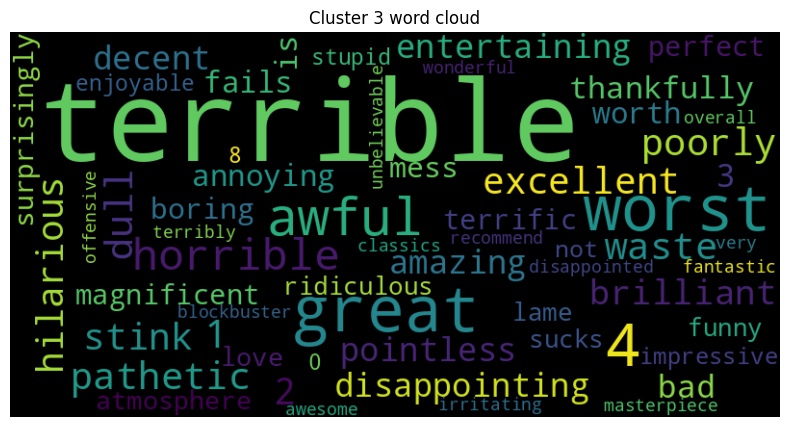

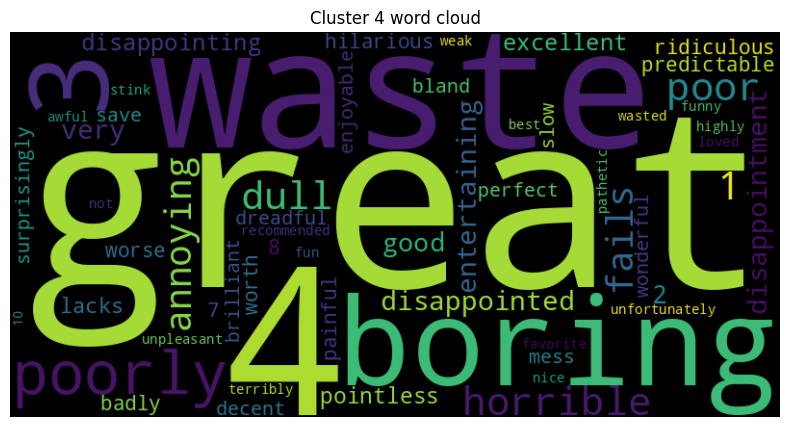

In [48]:
from wordcloud import WordCloud

def cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id, max_words=60):
    idxs = [i for i, c in enumerate(cluster_ids) if c == cluster_id]
    cluster_matrix = R_vocab[idxs]
    mean_sal = cluster_matrix.mean(axis=0)

    token_weights = {}
    for tok_id, w in enumerate(mean_sal):
        if w <= 0:
            continue
        tok = tokenizer.convert_ids_to_tokens([tok_id])[0]
        if tok in tokenizer.all_special_tokens:
            continue
        if tok.strip() == "":
            continue
        token_weights[tok] = float(w)

    wc = WordCloud(width=800, height=400, max_words=max_words)
    wc.generate_from_frequencies(token_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} word cloud")
    plt.show()

# visualize all clusters
for c in range(n_clusters):
    cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id=c)


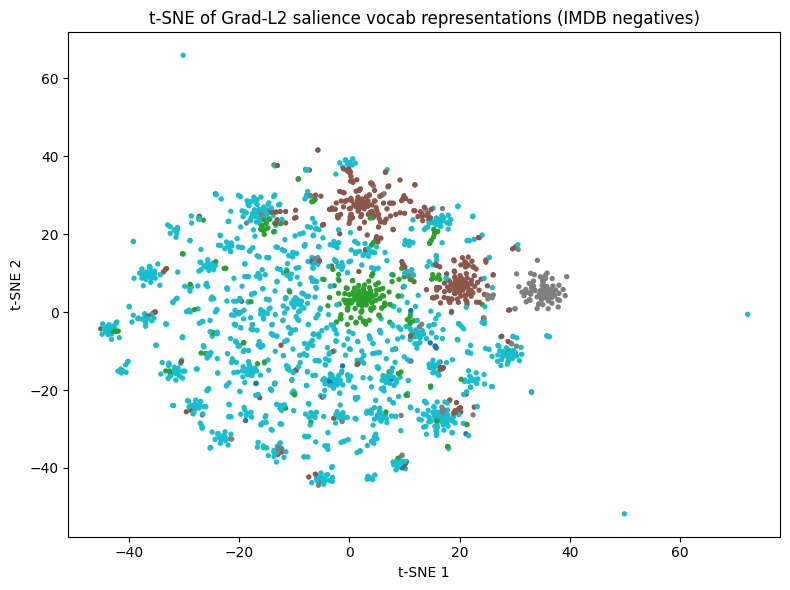

In [49]:
from sklearn.manifold import TSNE

def plot_tsne(R_vocab, cluster_ids, sample_size=2000):
    n = min(sample_size, R_vocab.shape[0])
    R_sub = R_vocab[:n]
    c_sub = cluster_ids[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c=c_sub, s=8, cmap="tab10")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE of Grad-L2 salience vocab representations (IMDB negatives)")
    plt.tight_layout()
    plt.show()

plot_tsne(R_vocab, cluster_ids)


In [50]:
import re

rating_pattern = re.compile(
    r"\b\d+\s*/\s*10\b|\b\d+\s*star[s]?\b|\b\d+\s*/\s*5\b",
    re.IGNORECASE,
)

def is_numeric_review(text: str) -> bool:
    return bool(rating_pattern.search(text))

labels_numeric = np.array([is_numeric_review(t) for t in texts_neg])

# pick numeric cluster by inspection of describe_clusters / word cloud
numeric_cluster_id = 0   # <-- change to the cluster index that looks numeric

cluster_mask = (np.array(cluster_ids) == numeric_cluster_id)

precision = labels_numeric[cluster_mask].mean() if cluster_mask.any() else 0.0
recall = (
    labels_numeric[cluster_mask].sum() / labels_numeric.sum()
    if labels_numeric.sum() > 0
    else 0.0
)

print(f"Numeric cluster {numeric_cluster_id}")
print(f"  Precision (fraction of reviews in cluster that are numeric): {precision:.2f}")
print(f"  Recall    (fraction of numeric reviews captured):            {recall:.2f}")


Numeric cluster 0
  Precision (fraction of reviews in cluster that are numeric): 0.11
  Recall    (fraction of numeric reviews captured):            0.02


In [51]:
import re
import numpy as np

rating_pattern = re.compile(
    r"\b\d+\s*/\s*10\b"      # e.g. 7/10
    r"|\b\d+\s*/\s*5\b"      # e.g. 3/5
    r"|\b\d+\s*star[s]?\b"   # e.g. 4 stars
    r"|\b\d+\s*/\s*4\b"      # 3/4, 2/4 etc.
    , re.IGNORECASE
)

def is_numeric_review(text: str) -> bool:
    return bool(rating_pattern.search(text))

labels_numeric = np.array([is_numeric_review(t) for t in texts_neg])  # texts_neg from your R_vocab build
cluster_ids_arr = np.array(cluster_ids)

def cluster_precision_recall(cluster_id: int):
    mask = (cluster_ids_arr == cluster_id)
    if not mask.any():
        return 0.0, 0.0

    # precision: among examples in this cluster, how many are numeric?
    precision = labels_numeric[mask].mean()

    # recall: among all numeric examples, how many lie in this cluster?
    total_numeric = labels_numeric.sum()
    if total_numeric == 0:
        recall = 0.0
    else:
        recall = labels_numeric[mask].sum() / total_numeric

    return precision, recall

for c in range(5):
    p, r = cluster_precision_recall(c)
    print(f"Cluster {c}: precision={p:.2f}, recall={r:.2f}")


Cluster 0: precision=0.11, recall=0.02
Cluster 1: precision=0.04, recall=0.06
Cluster 2: precision=0.08, recall=0.19
Cluster 3: precision=0.09, recall=0.07
Cluster 4: precision=0.08, recall=0.66
